<a href="https://colab.research.google.com/github/SmirnygaTotoshka/FBB_Courses/blob/main/L04_SVM_Crossvalidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Метод опорных векторов 

In [ ]:
from sklearn.svm import SVC
from sklearn import datasets 
import numpy as np
import matplotlib.pyplot as plt

Сегодня мы обсудим метод классического обучения, который, несмотря на то, что был предложен очень давно, до сих пор решает некоторые задачи на удивление с хорошим качеством. 

Начнем мы с посмотрим на вот такой игрушечный пример с датасетом, хранящим информацию о ирисах



Построим график, на котором отложим то, как делятся виды setosa и versicolor по длине и ширине лепестка  

In [ ]:
iris= datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]
setosa_or_versicolor = (y == 0) | (y == 1) 
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [ ]:
def plot_2iris(iris= datasets.load_iris()):
  X = iris["data"][:, (2, 3)]  # petal length, petal width
  y = iris["target"]
  setosa_or_versicolor = (y == 0) | (y == 1) 
  X = X[setosa_or_versicolor]
  y = y[setosa_or_versicolor]
  plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
  plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
  plt.ylabel("Petal width", fontsize=14)
  plt.xlabel("Petal length", fontsize=14)
  plt.axis([0, 5.5, 0, 2])

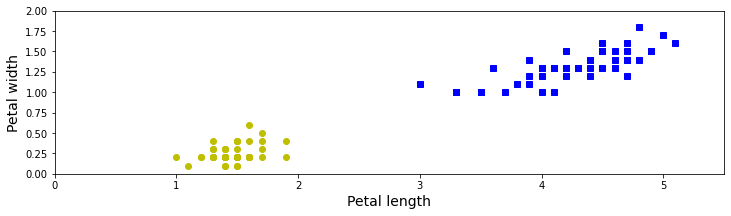

In [ ]:
plt.figure(figsize=(12,3))
plot_2iris()
plt.show()

Видим, что разделение идеально. 
Но мы хотим для любого цвветка, померив длину и ширину лепестка, говорить точно - к какому из двух видов он относится. Нам нужно провести границу - **решающую границу**, с одной стороны от которой мы говорим, что цветок - setosa, а с другой - versicolor

Но как ее провести? 

Можно так:

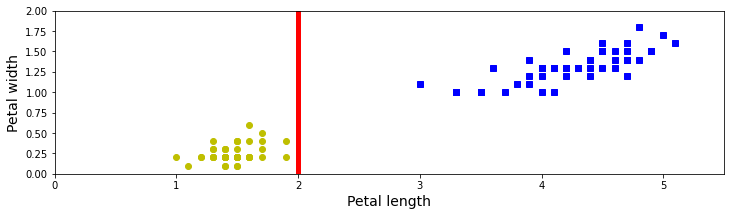

In [ ]:
plt.figure(figsize=(12,3))
plot_2iris()
plt.axvline(x=2, ymin = 0, ymax = 2, color="red", linewidth=5)
plt.show()

Или так

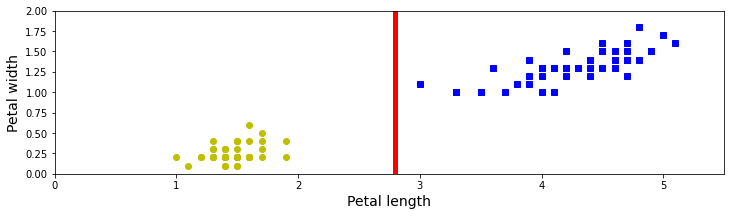

In [ ]:
plt.figure(figsize=(12,3))
plot_2iris()
plt.axvline(x=2.8, ymin = 0, ymax = 2, color="red", linewidth=5)
plt.show()

Вообще говоря, можно проводить не только горизонтальные линии. Можно и с наклоном

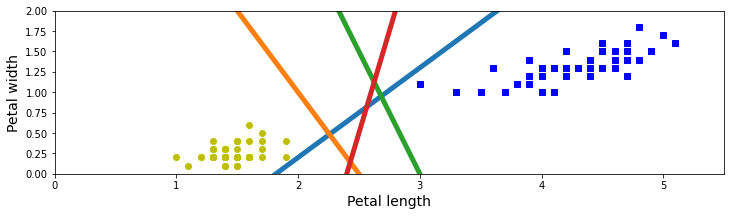

In [ ]:
plt.figure(figsize=(12,3))
plot_2iris()
x0 = np.linspace(0, 5, 200)
for (b, k) in ((1.1, 2), (-2, -5), (-3, -9), (5, 12)):
  y0 = b * x0 - k
  plt.plot(x0, y0, linewidth=5)
plt.show()

## Maximum margin classifier 

Мы хотим провести такую разделяющую границу, чтобы минимальное расстояние между ней и объектом из нашей обучающей выборки было максимально

$$\max_b \min dist(x, b)$$

$$ \min dist(x, b) $$ называется **зазором** (margin)

In [ ]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

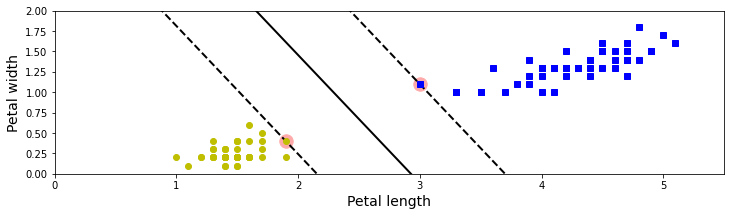

In [ ]:
svm_clf = SVC(kernel="linear", C=np.inf) 
svm_clf.fit(X, y)

x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

plt.figure(figsize=(12,3))
plot_svc_decision_boundary(svm_clf, 0, 5.5)

plot_2iris()
plt.show()

Вроде бы все работает замечательно. Но что произойдет, если мы добавим один выброс - цветок, который мы разметили неверно? 

In [ ]:
svm_clf = SVC(kernel="linear", C=np.inf) 
X_out = np.concatenate([X, np.array([3.2, 0.8]).reshape(1, 2)], axis=0)
y_out = np.concatenate([y, np.array([0])])

svm_clf.fit(X_out, y_out)

SVC(C=inf, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

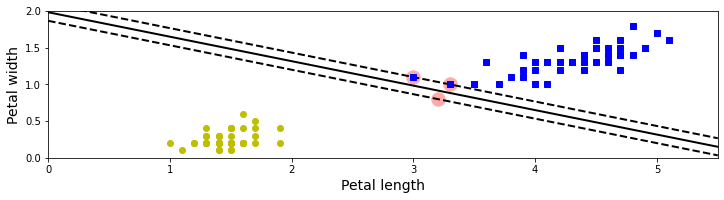

In [ ]:
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

plt.figure(figsize=(12,2.7))

plot_svc_decision_boundary(svm_clf, 0, 5.5)
plot_2iris()
plt.axis([0, 5.5, 0, 2])
plt.show()

Наше решение очень сильно поменялось. Всего из-за одного выброса. У наше модели большой variance - она чувствительна к шуму в данных.


Более того, мы можем добавить такой выброс, что мы в принципе не сможем провести прямую, которая однозначно разделит точки

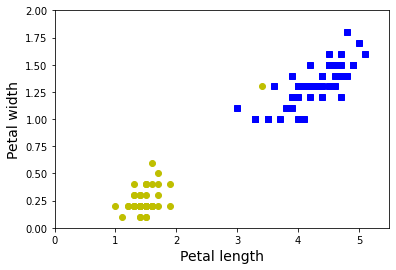

In [ ]:
X_out = np.concatenate([X, np.array([3.2, 0.8]).reshape(1, 2)], axis=0)
y_out = np.concatenate([y, np.array([0])])



X_out = np.concatenate([X, np.array([3.4, 1.3]).reshape(1, 2)], axis=0)
y_out = np.concatenate([y, np.array([0])])

plt.plot(X_out[:, 0][y_out==1], X_out[:, 1][y_out==1], "bs")
plt.plot(X_out[:, 0][y_out==0], X_out[:, 1][y_out==0], "yo")
plt.ylabel("Petal width", fontsize=14)
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])
plt.show()

## Soft Margin Classifier = Support Vector Classifier

Разрешим нашей модели частично игнорировать выбросы. Пусть за то, насколько сильно модель может проигнорировать выбросы, будет отвечать параметр C. Чем он больше - тем бОльший штраф мы даем за любой объект, который лежит не с той стороны обучающей выборки

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/svm_c.png" width="400">

В такой постановке разделение возможно

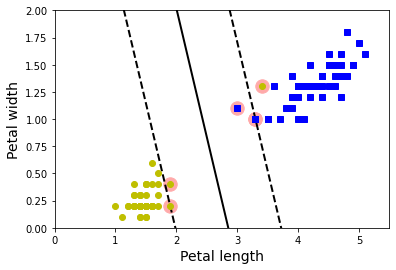

In [ ]:
X_out = np.concatenate([X, np.array([3.4, 1.3]).reshape(1, 2)], axis=0)
y_out = np.concatenate([y, np.array([0])])

svm_clf = SVC(kernel="linear", C=1) 
svm_clf.fit(X_out, y_out)

plot_svc_decision_boundary(svm_clf, 0, 5.5)

plt.plot(X_out[:, 0][y_out==1], X_out[:, 1][y_out==1], "bs")
plt.plot(X_out[:, 0][y_out==0], X_out[:, 1][y_out==0], "yo")
plt.ylabel("Petal width", fontsize=14)
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])
plt.show()

Меняя параметр C, мы будем менять и чувствительность нашего решения к шуму - чем больше C - больше мы реагируем на шум

## Метод опорных векторов 

По сути мы с вами получили метод опорных векторов. Остается один вопрос - а почему метод вдруг назван методом **опорных векторов**

support vectors 

Оказыввается, то, с какой стороны от решающей границы лежит объект, который мы классифицируем определяется методом на основании **decision function**. Если ее значение меньше 0 - объект лежит со стороны нулевого класса, больше - со стороны 1 класса. 



Сама же функция вычисляется по следующей формуле:

$$ decision_j = \sum_{i \in train\_objects} c_i y_i <x_i, x_j> + b $$



Что в ней написано? 

Для определения решения для некоего объекта j, мы считаем сумму его скалярных произведений с объектами выборки, умноженными на некий коэффициент $c_i$ и метку класса $y_i$. 

Скалярное произведение мы считаем в пространстве признаков наших объектов. 

y_i принимает значение -1 для объектов нулевого класса и +1 для позитивного

Остается разобраться с $c_i$ 


Этот коэффиент равен 0 почти для всех обхектов из тренировочной выборки кроме тех, что определяют границу (на рисунке подсвечены)

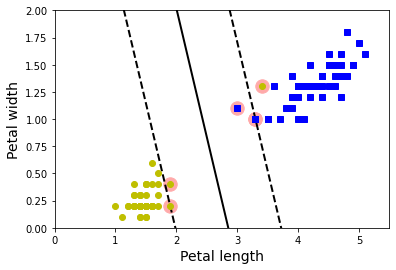

In [ ]:
X_out = np.concatenate([X, np.array([3.4, 1.3]).reshape(1, 2)], axis=0)
y_out = np.concatenate([y, np.array([0])])

svm_clf = SVC(kernel="linear", C=1) 
svm_clf.fit(X_out, y_out)

plot_svc_decision_boundary(svm_clf, 0, 5.5)

plt.plot(X_out[:, 0][y_out==1], X_out[:, 1][y_out==1], "bs")
plt.plot(X_out[:, 0][y_out==0], X_out[:, 1][y_out==0], "yo")
plt.ylabel("Petal width", fontsize=14)
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])
plt.show()

Все объекты, у которых $c_i != 0$ и называются опорными векторами. Формула может быть переписана, тем самым, следующим образом:

$$ decision_j = \sum_{i \in support\_vectors} c_i y_i <x_i, x_j> + b $$



То есть решение о принадлежности объекта к тому или иному классу выносится на основе (обычно) малой части тренировочной выборке - опорных векторах - потому метод и называется методом опорных векторов

## Переход в пространство большей размерности

Представим себе, что в исходном пространстве признаков наши объекты в принципе неразделимы.






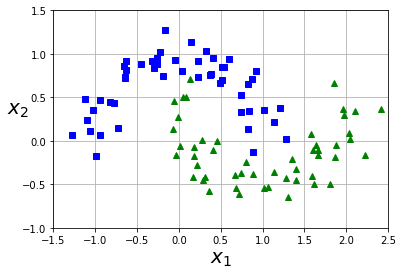

In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

Тогда кажется разумным перейти в пространство бОльшей размерности и уже там применить наш метод.


Например, можно взять и вместо исходных признаков 

$$x_1, x_2$$

применять их комбинации вплоть до третьей степени получающегося полинома 

$x_1,~x_2,~x_1^2,~x_2^2,~x_1x_2, ~x_1^2x_2,~x_2^2x_1,~x_1^3,~x_2^3 $

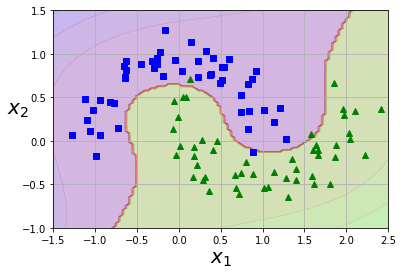

In [ ]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)


clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

clf.fit(X, y)
plot_predictions(clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

Подход работает, но есть один нюанс. 

Что произойдет, если пространство признаков, в которое нам надо перейти - велико, и объектов у нас много? 

Скорее всего - мы просто не сможем обучить модель. Кончится оперативная память и все упадет. 

### Kernel trick 

Но в случае SVM за счет того, что функция решений выглядит следующим образом:

$$ decision_j = \sum_{i \in support\_vectors} c_i y_i <x_i, x_j> + b $$

можно сделать иначе. Для подсчета ее значения нам не нужно знать, как выглядят объекты в пространстве бОльшей размерности, а только уметь узнавать скалярное произведение между ними.

Оказывается, в некоторых случаях это можно делать, не переходя в это пространство, а вычисляя специальную **kernel function**

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/svm_kernel_trick.png" width="500">

Примеры ядер :

* $k(x_i, x_j) = (<x_i, x_j> + c)^d, с, d \in \mathbb{R}$ - полиномиальное ядро, считает расстояние между объектами в пространстве размерности d

* $k(x_i, x_j) = \frac{1}{z} e^{-\frac{h(x_i, x_j)^2}{h}}$ - радиальная базисная функция RBF





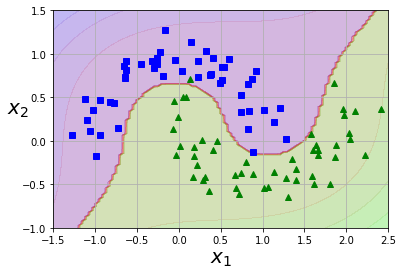

In [ ]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)



clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=10))
    ])

clf.fit(X, y)
plot_predictions(clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

## Вероятности

SVM сам по себе не умеет предсказывать вероятности. Есть только decision function. 

К этому можно отнестись философски, так как многим методам/оценкам вероятность и не нужна. Тому же roc-auc нужен именно y_score.

В чисто виде decision function применять в роли вероятности нельзя - она не ограничена на отрезке от 0 до 1, у нее нет точного максимума и точного минимума. Кроме того, она плохо отображает вероятность (даже если мы отнормируем ее как-то в отрезок от 0 до 1):

In [ ]:
# sklearn
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss
def plot_calibration_curve(clf, X_test, Y_test, name='classifier'):
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    y_pred = clf.predict(X_test)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    clf_score = brier_score_loss(Y_test, prob_pos, pos_label=y.max())
    fraction_of_positives, mean_predicted_value = \
            calibration_curve(Y_test, prob_pos, n_bins=10)

    plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                label="%s Score=(%1.3f)" % (name, clf_score))


    plt.ylabel("Fraction of positives")
    plt.ylim([-0.05, 1.05])
    plt.legend(loc="best")

In [ ]:
from sklearn.model_selection import train_test_split
X, Y = datasets.make_classification(n_samples=10000, n_features=20,
                                    n_informative=2, n_redundant=10,
                                    random_state=777)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.99,
                                                    random_state=777)

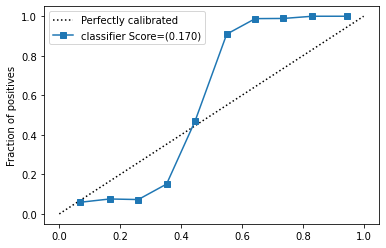

In [ ]:
svm = SVC(kernel="linear")
svm.fit(X_train, Y_train)
plot_calibration_curve(svm, X_test, Y_test)

В идеале, если модель предсказывает вероятность 0.2, то только 20% объектов, для которых предсказана такая вероятность, должны относиться к 1 классу. И аналогично для других вероятностей. 

В нашем же случае мы видим серьезное отклонение

Но можно получить вероятности из decision function специальной процедурой. Конкретно - подаем decision function в качестве единственного признака классификатору, который вероятности предсказывать умеет.

Например, логистической регресии

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/platt_scaling.png" width="500">

Можно ли учить логистическую регрессию на той же выборке, на которой учили SVM? Нет. 

Потому используем либо отдельный валидационный датасет. Либо учимся kfold кроссвалидацией, которую разберем позже.

### Plat scaling

Процедура реализована в SVM и ее можно запустить передав нужный параметр

Что мы хотим видеть для вероятностей, предсказываемых идеальным классификатором?

Мы хотим, чтобы доля объектов, принадлежащих классу X, для которых классификатор выдал вероятность p принадлежать классу X, была равна p

Если разбить все наши объекты на бины по предсказываемым вероятностям, то можно для каждого бина посчитать долю объектов целевого класса и построить полученную зависимость. В идеале должна получиться прямая

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X, Y = datasets.make_classification(n_samples=10000, n_features=20,
                                    n_informative=2, n_redundant=10,
                                    random_state=777)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.99,
                                                    random_state=777)

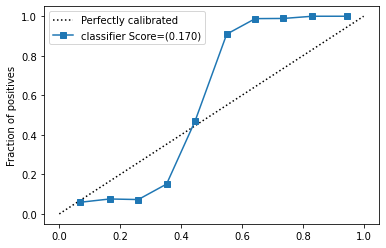

In [ ]:
svm = SVC(kernel="linear")
svm.fit(X_train, Y_train)
plot_calibration_curve(svm, X_test, Y_test)

Можем применить встроенный в SVC Plat Scaling

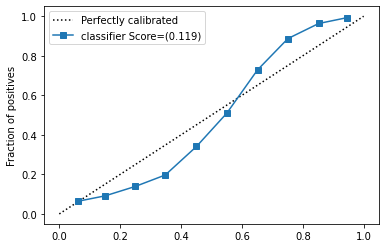

In [ ]:
svm = SVC(kernel="linear",  probability=True)
svm.fit(X_train, Y_train)
plot_calibration_curve(svm, X_test, Y_test)

## Переход от бинарной классификации к мультиклассовой

Напрямую, мы не можем при помощи такого SVM решить задачу классификацию, отличную от бинарной. Поэтому чаще всего SVM упоминается в контекста бинарной классификации. 

Однако существуют подходы, позволяющие использовать SVM и для мультиклассовой классификации

Один из них состоит в обучении множества бинарных классификаторов отличать:
1. класс 0 от остальных
2. класс 1 от остальных
3. ....

И далее выбирать класс, про который предсказание было наиболее верным

![alttext](https://matlab4engineers.com/wp-content/uploads/2017/11/intro1.png)

## Задача регрессии

Можно адаптировать метод опорных векторов и для задачи регрессии. Однако разбирать в курсе теорию этого мы не будем

# Применение метода опорных векторов в биологии

Метод опорных векторов до сих применяется в биологии, так как он хорошо работает на малых объемах данных. С правильно заданным пространством признаков SVM может работать лучше, чем нейросеть, обучаемая с "нуля". 

К недостаткам SVM можно отнести сравнительно малую скорость обучения модели и то, что при увеличении количества данных, качество SVM растет не так быстро, как у других методов. Кроме того, transfer learning с примением в качестве исходной модели SVM затруднителен. 

Рассмотрим пример одного из наиболее успешных применений SVM в биологии - gkmSVM + deltaSVM

### k-mer для классификации последовательностей 

Часто перед нами встает следующая задача: есть последовательности, содержащие определенный сигнал и последовательности, его не содержащие. 
Необходимо научиться отличать одни последовательности от других. 

Для решения такого рода задач можно использовать методы машинного обучения. Остается как-то описать наши последовательности. 



Часто для описания последовательностей используют просто то, сколько kmer - подпоследовательностей длины k встречается в каждой из них 


<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/kmer.png" width="500">

Описывать можно по-разному - например, сколько раз каждый kmer встретился 
Или просто - встретился kmer или нет



<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/kmer_count.png" width="500">

In [ ]:
from itertools import product

def all_kmers(kmer_size):
    return [''.join(x) for x in product(*["ATGC" for i in range(kmer_size)])]

def kmer_count(seq, kmer_size):
    dt = {x: 0 for x in all_kmers(kmer_size) }
    print(dt)
    for i in range(0, len(seq) - kmer_size):
        kmer = seq[i:i+kmer_size]
        dt[kmer] += 1
    return dt

In [ ]:
kmer_count("ATGAAG", 2)

{'AA': 0, 'AT': 0, 'AG': 0, 'AC': 0, 'TA': 0, 'TT': 0, 'TG': 0, 'TC': 0, 'GA': 0, 'GT': 0, 'GG': 0, 'GC': 0, 'CA': 0, 'CT': 0, 'CG': 0, 'CC': 0}


{'AA': 1,
 'AC': 0,
 'AG': 0,
 'AT': 1,
 'CA': 0,
 'CC': 0,
 'CG': 0,
 'CT': 0,
 'GA': 1,
 'GC': 0,
 'GG': 0,
 'GT': 0,
 'TA': 0,
 'TC': 0,
 'TG': 1,
 'TT': 0}

#### Проблема подхода 

Основная проблема данного подхода - экспоненциальное увеличение числа различных kmer - а, следовательно, и объема потребляемой памяти. 

Кроме того, признаки становятся очень разреженными, и чем большие k используются, тем больше видна проблема того, что kmer, отличающиеся на одну букву, считаются абсолютно разными в таком признаковом пространстве. 

## gkmSVM

Для решения этой проблемы были предложены **gapped kmers** - когда мы учитываем, что два kmer, которые отличаются друг от друга каким-то числом замен или вставок/удалений - тоже похожи. 


<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/gapped_kmer.png" width="500">

Модель, которая использует это при классификации последовательностей - gkmSVM (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4937197/)

## deltaSVM

gkmSVM работает долго, в том числе на предсказании, где это критично. Можно огрубить модель. 







Для этого они предложили делать следующее 

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/deltaSVM1.png" width="500">

Сначала обучаем gkmSVM модель разделять последовательности с сигналом и без него. 

После этого, при помощи decision function gkmSVM скорим все возможные kmer определенного размера, например, 10меры. 



Теперь можем быстро получать оценку для каждой последовательности 

<img src="https://kodomo.fbb.msu.ru/FBB/year_21/deltaSVM0.5.png" width="500">


Далее автора gkmSVM предложили интересный подход для другой задачи - классификации замен в регуляторных регионах генома на нейтральные и вредные. 


<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/deltaSVM2.png" width="500">

После этого делаем следующее - пусть у нас есть исходная последовательность и мы хотим оценить эффект внесения однонуклеотидной мутации в нее. 

Возьмем все kmer, которые включают позицию замены в исходной последовательности и в мутированной. 
Для каждого kmer возьмем скор, который дает ему gkmSVM. 

Отдельно сложим скоры kmer для исходной последовательности и для мутированной, вычтем полученные суммы одну из другой. 
Полученный скор будет характеризовать эффект замены. 




Действительно, оказывается, что большие положительные значения скора корреляруют с увеличением сввязывания того или иного фактора / открытости хроматина, а маленькие - у уменьшением. 

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/deltaSVM3.png" width="700" height="400">



# Особенности валидации с биологическими данными

### Train-test split

На прошлых занятиях мы использовали следующую схему разбиения 

<img src="https://conlanscientific.com/media/content/splitting-data.png" width="500">

Оно предполагает, что мы наши данные **независимы**. Нет копий каких-то объектов, нет зашумленных версий каких-то объектов  и т.д.

Если это не выполняется - то наша оценка качества модели сильно проседает. 

Для биологических данных постоянно нарушается предположение о том, что объекты в выборке, которую мы получили - независимы. 





## Медицинские изображения

Проблема с правильной кросс-валидацией [указывается](https://www.technologyreview.com/2021/07/30/1030329/machine-learning-ai-failed-covid-hospital-diagnosis-pandemic/), в числе прочих, и среди причин невозможности применения кучи опубликованных моделей для реальной диагностики ковида.

Более того, много статей, к примеру - [из недавних](https://www.nature.com/articles/s42256-021-00307-0) - посвящено тому, как правильно делать исследование на медицинских изображениях. И там упоминается и проблема кроссвалидации. 



В снимках могут быть фотографии, полученные от одного пациента. Могут быть снимки с одного прибора, окрашенные одним и тем же специфичным способом и т.д.

<img src="https://kodomo.fbb.msu.ru/FBB/year_21/cross_patient.png" width="500">



## Нуклеотидные последовательности и Biasaway

Очень часто последовательности, содержащие сигнал и без сигнала отличаются по GC-контенту - относительному содержанию нуклеотидов G и C в последовательности. 

Особенно этому подвержены ситуации, когда последовательностями без сигнала мы считаем случайным образом взятые последовательности из генома. 

Большая часть моделей может легко вывести из поданных им на вход признаков GC-контент и классифицировать выборки на его основании. 



In [ ]:
!gdown https://drive.google.com/uc\?id=1TOpoivIwMHEvWm-MSszd2UaYn42-CJt2 -O negative.fasta.gz
!gdown https://drive.google.com/uc\?id=14ts2nq0U1v2cP73npKJQzsG1OHjE_OhS -O positive.fasta.gz

Downloading...
From: https://drive.google.com/uc?id=1TOpoivIwMHEvWm-MSszd2UaYn42-CJt2
To: /content/negative.fasta.gz
100% 10.6M/10.6M [00:00<00:00, 92.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=14ts2nq0U1v2cP73npKJQzsG1OHjE_OhS
To: /content/positive.fasta.gz
100% 28.6M/28.6M [00:00<00:00, 90.8MB/s]


In [ ]:
!pip install pyfastx 

In [ ]:
import pyfastx

In [ ]:
fa = pyfastx.Fasta('positive.fasta.gz')
gc_array_pos = []
ind = 0
for seq in fa:
    ind += 1
    gc_array_pos.append(seq.gc_content)
    if ind == 10000:
        break

In [ ]:
fa = pyfastx.Fasta('negative.fasta.gz')
gc_array_neg = []
ind = 0
for seq in fa:
    gc_array_neg.append(seq.gc_content)
    ind += 1
    if ind == 10000:
        break

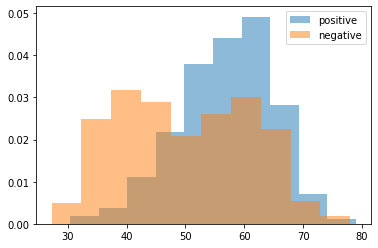

In [ ]:
plt.hist(gc_array_pos, label="positive", density=True, alpha=0.5)
plt.hist(gc_array_neg, label="negative", density=True, alpha=0.5)
plt.legend()
plt.show()

Для борьбы с этим (и похожими проблемами) существует программа [BiasAway](https://biasaway.uio.no/), которая пытается выбрать последовательности из негативной выборки таким образом, чтобы содержание GC между позитивным и негативным классом не отличалось 

## Cross-chromosome и cross-cell validation 



Когда мы делаем предсказания на геномных данных, необходимо быть ОЧЕНЬ внимательным. 

Многие сигналы, такие как доступность хроматина, опасность мутаций в позиции и т.д обладают выраженной локальностью - по рядом стоящей позиции можно с большой достоверностью предсказать значение в текущей позиции. 

Некоторые сигналы более-менее сохраняют свое значение на больших участках генома, а модели машинного обучения склонны легко запоминать конкретные последовательности и "составлять" внутри себя карту генома. 


Представим себе ситуацию, что у нас есть данные двух клеточных линий для всех хромосом

<img src="https://kodomo.fbb.msu.ru/FBB/year_21/genome_cross0.png" width="600">

Как мы можем разбить наши данные на обучение и тест? 

### Случайное разбиение

Не рекомендуется - модель почти наверняка переобучится

<img src="https://kodomo.fbb.msu.ru/FBB/year_21/genome_cross1.png" width="600">

### Разбиение по клеточным линиям

Лучше, но надо сравниваться с предсказанием среднего по линиям, на которых училась модель

<img src="https://kodomo.fbb.msu.ru/FBB/year_21/genome_cross2.png" width="600">

### Разбиение по хромосомам

Хороший вариант, ловит почти все проблемы 

<img src="https://kodomo.fbb.msu.ru/FBB/year_21/genome_cross3.png" width="600">

### Разбиение по длинным участкам

Можно в обучение брать одни протяженные участки, а в тест - другие. 
Проблема - можно обмануться с необходимым размером.

Достаточно безопасно брать половинки хромосом

<img src="https://kodomo.fbb.msu.ru/FBB/year_21/genome_cross4.png" width="600">

### TargetFinder

Представим себе следующую задачу: 
1) дана последовательность энхансера
2) дана последовательность промотора
3) предсказать, будут ли они взаимодействовать

Автор TargetFinder в данной задаче смогли добиться точности порядка 99% процентов. Кажется подозрительным. 

И в скором времени вышла статья, где было показано, что все качество авторов происходит из-за неправильного разбиения данных. 
В выборку попадали последовательности из одной и той же хромосомы, более того, один и тот же промотор/энхансер могли быть как в обучении, так и в тесте. 

Признаки, которые они предложили, позволяли модели легко запоминать конкретные промоторы и энхансеры, понимать, что лежит в окружении того или иного регуляторного участка. 

Как было показано, что в модели есть проблемы - просто предложили два разбиения - кросс-хромосомное, когда в тест попадали пары промотор-энхансер только с одних хромосом, а в трейн - с других. 

И второе - где хотя бы гарантировалось, что один и тот же промотор будет либо только в тесте, либо только в обучении. 

Второе разбиение было более мягким - на нем модель все равно находила "как переобучиться". На кросс-хромосомном уровне data leakage убирался полностью. 

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/crosschromosome.png" width="700">


### A pitfall for machine learning methods aiming to predict across cell types

Аналогичный эффект был [продемонстрирован](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-02177-y) при попытке обучить модель, предсказывающую, какие гены будут значимо экспрессироваться в клеточной линии. "Лучшим" предсказанием сигнала для определенной клеточной линии оказывается просто предсказание для данного гена среднего по остальным клеточным линиям. 

Модель же "стремится" к идеалу - чем больше ей дается параметров, тем лучше она запоминает и тем больше ее предсказание становится похоже на среднее

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/expression.png" width="700">

### Avocado

В [статье](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-01977-6) используют неправильные разбиения, что были еще в TargetFinder

![alttext](https://media.springernature.com/lw685/springer-static/image/art%3A10.1186%2Fs13059-020-01977-6/MediaObjects/13059_2020_1977_Fig5_HTML.png?as=webp)

### CAGI2018

Авторы конкурса недооценили размер блоков, на которые надо резать геномные данные (**A**) и в итоге модель уучила не признаки, важные для предсказания эффекта мутации, а призниак, важные для предсказания, какой объект из обучающей выборки был ближе **по геному**. 

Соответственно, при правильных разбиениях большая часть моделей [показывали](https://www.frontiersin.org/articles/10.3389/fgene.2019.01078/full) куда меньшее качество и были не переносимы на реальные данные, где все последовательности относятся к тем, которые модели не видели

<img src="https://www.frontiersin.org/files/Articles/485085/fgene-10-01078-HTML/image_m/fgene-10-01078-g001.jpg" width="600">

В результате, даже модель, обученная на абсолютно случайных признаках, показывала качество лучше многих конкурсных решений 

<img src="https://kodomo.fbb.msu.ru/FBB/year_21/cagi2018_fakesig.png" width="500">

## Разбиение химических веществ 

### Разные разбиения - разные результаты

Аналогичная проблема может возникнуть и при разбиении химических веществ.

Допустим, что вы хотите предсказывать связывание белка с веществом 

В [статье](https://arxiv.org/abs/1703.10603) приводят пример, что в зависимости от того, как разбить комплексы белков с веществами на обучение и тест, оценка качества может меняться очень разными путями. 

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/chemsplit.png" width="700">

### Датасеты могут быть разные по качеству

Бывают хорошие датасеты, где для каждого белка известны как ингибиторы, так и вещества ими неявляющимися. И для каждого вещества известны и белки, с которыми оно связывается, и с которыми нет. 
В этом случае может повезти - и любое разбиение будет давать вам хорошее качество 

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/chembase1.png" width="700">





Бывают же датасеты, где для каких-то веществ изввестны только белки, которые они ингибируют (ученые любят сообщать об успехах, а не о неудачах) или белки, для которых известны только ингибиторы (или ингибиторов неизвестно). 

В этом случае без правильного разбиения - хорошо оценить качество модели не получится. 

### Разбиение по веществу 

Информация про одно и то же вещество идет либо только в обучение, либо только в тест. 

### Разбиение по scaffold 

Разбиение по структуре вещества. Например, на основании [Bemis-Murcko scaffold](https://docs.chemaxon.com/display/docs/bemis-murcko-clustering.md)


<img src="https://kodomo.fbb.msu.ru/FBB/year_21/bemismurko_scaf.jpeg" width="500">

### Разбиение по белку

Комплексы одного и того же белка идут либо только в обучении, либо в тест. 

### Разбиение по семействам

Есть разные разбиения белков на классы по похожести. 

Можем брать белки из одного класса либо только в обучение, либо только в тест. Или можно напрямую контролировать, чтобы похожесть между последовательностями в обучении и тесте не была больше заданного порога



![alttext](https://d3i71xaburhd42.cloudfront.net/67fdfd931031a2cce96e5f1d06369e06ce9e6bae/8-Figure3-1.png)

## Медицинские записи

В медицинских записях так же [могут](https://www.sciencedirect.com/science/article/pii/S153204641830073X) встречаться полные дупликаты или почти-дупликаты. Если не очистить датасет от них предварительно или не обеспечить праавильного разбиения - получится неправильная оценка качества модели

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S153204641830073X-fx1_lrg.jpg" width="600">

## RNA-Seq

Бывает и [такое](https://www.biorxiv.org/content/10.1101/2020.09.09.290395v1.full)

>The testing data was held by a separate analysis group 
using a different computer system to avoid any possibility 
of inadvertent use of test data in the model building 
process.



Но вообще проблема серьезная. На прошой лекции уже был пример

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1b5XLe7hVBv2Y0xiXaG0-SGGAk4HLSOTl' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1b5XLe7hVBv2Y0xiXaG0-SGGAk4HLSOTl" -O gse53625_expression.csv && rm -rf /tmp/cookies.txt

--2021-10-07 12:39:28--  https://docs.google.com/uc?export=download&confirm=o5Zh&id=1b5XLe7hVBv2Y0xiXaG0-SGGAk4HLSOTl
Resolving docs.google.com (docs.google.com)... 74.125.199.100, 74.125.199.101, 74.125.199.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.199.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-1s-docs.googleusercontent.com/docs/securesc/jr46sc8gv0gffk21hrgrgckrmhclb6n7/otqgkrqkfh1eso21iv8bkmpel3prak5p/1633610325000/10688067377005935076/06484226536183894080Z/1b5XLe7hVBv2Y0xiXaG0-SGGAk4HLSOTl?e=download [following]
--2021-10-07 12:39:28--  https://doc-0g-1s-docs.googleusercontent.com/docs/securesc/jr46sc8gv0gffk21hrgrgckrmhclb6n7/otqgkrqkfh1eso21iv8bkmpel3prak5p/1633610325000/10688067377005935076/06484226536183894080Z/1b5XLe7hVBv2Y0xiXaG0-SGGAk4HLSOTl?e=download
Resolving doc-0g-1s-docs.googleusercontent.com (doc-0g-1s-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1vhCwAOc0v8HE75Q-47sWmETAmi_JiH7N' -O gse53625_metadata.csv

--2021-10-07 12:39:30--  https://docs.google.com/uc?export=download&id=1vhCwAOc0v8HE75Q-47sWmETAmi_JiH7N
Resolving docs.google.com (docs.google.com)... 74.125.195.101, 74.125.195.100, 74.125.195.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-50-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/uauug7daonrrj93b43f4gqa2rj39io5j/1633610325000/10688067377005935076/*/1vhCwAOc0v8HE75Q-47sWmETAmi_JiH7N?e=download [following]
--2021-10-07 12:39:30--  https://doc-0c-50-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/uauug7daonrrj93b43f4gqa2rj39io5j/1633610325000/10688067377005935076/*/1vhCwAOc0v8HE75Q-47sWmETAmi_JiH7N?e=download
Resolving doc-0c-50-docs.googleusercontent.com (doc-0c-50-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-0c-50-docs.googleusercontent.com (doc-0c-50-d

In [ ]:
escc = pd.read_csv("./gse53625_expression.csv", index_col=0)
escc_meta = pd.read_csv("./gse53625_metadata.csv", index_col=0)

In [ ]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def draw_pca_chart(df: pd.DataFrame, y_column=None, normalize=True, vis_type="PCA", seed=42):
    assert vis_type.lower() in ["pca", "tsne", "umap"], "Incorrect visualization type/ Allowed: 'pca', 'tsne', 'umap'"

    df = df.copy()
    if y_column is None:
        y = pd.Series(index=df.index, data=0, name=None)
    elif isinstance(y_column, str):
        assert y_column in df.columns, f"{y_column} is not in DataFrame"
        y = df.pop(y_column)
    elif isinstance(y_column, pd.Series):
        y = y_column
    df = df.select_dtypes(include=np.number)
    X = df.values
    
    if normalize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    
    if vis_type.lower() == "pca":
        pca = PCA(n_components=2) # no kernel pca
        X_transf = pca.fit_transform(X)
    elif vis_type.lower() == "tsne":
        tsne = TSNE(n_components=2, random_state=seed) # no distance
        X_transf = tsne.fit_transform(X)
    elif vis_type.lower() == "umap":
        um = umap.UMAP(n_components=2, random_state=seed) # no distance 
        X_transf = um.fit_transform(X)
    
    df = pd.DataFrame({"Component 1": X_transf[:,0],
                       "Component 2": X_transf[:,1],
                       y.name: y})
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="Component 1", y="Component 2", hue=y.name, data=df, alpha=0.75)
    plt.title(f"{vis_type} analysis", fontsize=16)

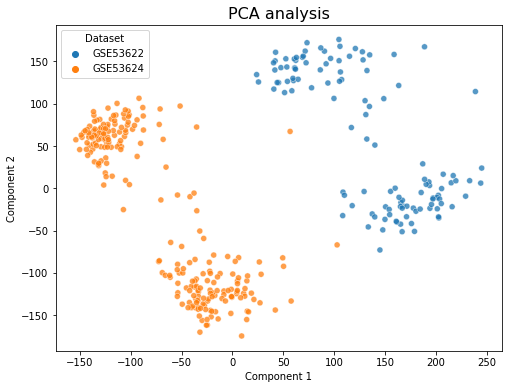

In [ ]:
draw_pca_chart(escc.T, escc_meta["Dataset"], normalize=False)

Решить эту можно по-разному. Но она не всегда решается и не всегда **можно заметить**, что она не решилась.

Потому правила те же - бить данные по пациентам/больницам и тд. 

## Гомологичные последовательности

При работе с белковыми последовательностями также стоит учитывать то, что они могут образовывать кластеры очень похожих друг на друга последовательностей. 
Обычно, чем меньше похожесть последовательностей из трейна и теста друг на друга, тем сложнее оказывается задача. 

Например, в [задаче предказания GO-аннотации](https://www.nature.com/articles/s41598-020-80786-0) качество модели падает (местами дяо качеста классических методов), по мере увеличения похожести между обучением и тестом

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/go_pred.png" width="700">



## Общая рекомендация 

Всегда думайте, что в Вашей задаче является источником распределения, генерирующего данные. Отсюда вытекают cross-chromosome, cross-cell line, cross-patient и прочие валидации...

#  Гиперпараметры и кросс-валидация

Текст для ознакомления - <a href='https://arxiv.org/pdf/1811.12808.pdf'>Крайне рекомендуется к прочтению!</a>

Мануалы sklearn по  <a href='https://scikit-learn.org/stable/modules/cross_validation.html'>кросс-валидации</a> тоже рекомендуются.

## Гиперпараметры

Есть параметры, а есть гиперпараметры.

<b>Параметры</b> - т.н. "веса" модели, т.е. то, что подбирается во время обучения. <br>

Например, у нас есть N признаков и мы строим на них линейную регрессию

$$y = w_0 + w_1 x_1 + w_2x_2 +~...~+ w_n x_n$$

В этом случае параметры, это веса $w_i$

В случае SVM параметрами будут веса $c_i$ объектов из тренировочной выборки



<b>Гиперпараметры</b> - те характеристики модели, которые фиксируются до обучения, влияют на процесс обучения, и не меняются сами во время обучения. 

Например, мы уже знакомы с гиперпараметром <b>k в алгоритме kNN</b> и гиперпараметром <b>C</b>  SVM. 

<img src="https://miro.medium.com/max/800/1*2zYNhLc522h0zftD1zDh2g.png" width="300">


### Отбор признаков

*С некоторой точки зрения, набор используемых признаков тоже можно считать гиперпараметром.*

Создадим таблицу 200 на 10000 со "здоровыми" и "больными" пациентами и данными об наличии-отсутствии определенных SNP 

In [ ]:
import numpy as np 
import pandas as pd

In [ ]:
snp_count = 10000
genes = [f"Gene{ind}" for ind in range(snp_count)]
healthy = pd.DataFrame(np.random.binomial(1, 
                                          0.5, 
                                          size=(100, snp_count) ), 
                       columns=genes)
healthy['State'] = "H"
diseased = pd.DataFrame(np.random.binomial(1, 
                                          0.5, 
                                          size=(100, snp_count)) ,
                        columns=genes)
diseased['State'] = "D"
patients = pd.concat([healthy, diseased], axis=0)

In [ ]:
from scipy.stats import pearsonr

In [ ]:
qual = {}
for gene in genes:
    corr = (pearsonr(patients[gene], patients['State'] == "H"))[0]
    qual[gene] = corr

In [ ]:
genes = sorted(qual, key=lambda x: -qual[x])[0:10]

In [ ]:
data_selected = patients[genes]

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, Y_train, Y_test = train_test_split(data_selected, 
                                                    patients['State'])

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
(y_pred == Y_test).mean()

0.68

Данные были РАНДОМНЫЕ. А получился отличный результат

## Разбиение данных

Помните, как примерно выглядит пайплайн в машинном обучении? 


<img src="https://kodomo.fbb.msu.ru/FBB/year_21/pub_ml_scheme.png" width="400">

<b>Во время процесса получения оптимальной модели встаёт множество вопросов:</b>

* Какие значения гиперпараметров оптимальные?
* Какой набор признаков позволяет достичь наибольшего качества?
* Как корректно сравнивать разные обученные модели между собой? 
* Как, в конце концов, оценить обобщающую способность модели?

Для получения корректных ответов на все эти вопросы сначала необходимо построить правильную схему разбиения данных.

### Все - train

> Дайте мне 4 параметра - и я нарисуя слона. 5 - и он будет вилять хоботом

[Источник](https://fermatslibrary.com/s/drawing-an-elephant-with-four-complex-parameters)


<img src="https://kodomo.fbb.msu.ru/FBB/year_21/elephant_45.png" width="400">


### Train-test split

<img src="https://conlanscientific.com/media/content/splitting-data.png" width="500">

### ~~Тест~~ 

<img src="http://img10.joyreactor.cc/pics/comment/anon-3009343.jpeg" width="500px">


<img src="https://kodomo.fbb.msu.ru/FBB/year_21/ml_scheme_stat.png" width="500px">

>Тестовая выборка - всего лишь символ. Это люди дают символам силу.

Делать такое разбиение нужно так, чтобы тестовые данные имитировали "новые" данные, и на них мы бы оценили обобщающую способность итоговой модели. <b>Тестовый набор данных используется всего один раз!</b><br>

### Почему нельзя сделать трейн-тест сплит и подбирать гиперпараметры на тесте?

В таком сценарии происходит переобучение на тестовый датасет, и он по сути превращается в тренировочный для гиперпараметров. 

Представим себе, что у нас есть 10000 моделей, полученных подкручиванием разных гиперпараметров. Представим, что все эти модели не работают, т.е. представляют из себя случайное угадывание. 

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np 
import warnings


warnings.filterwarnings('ignore')


def guess_model(y_real):
    guessed = np.random.choice([True, False],
                               size=y_real.shape[0],
                               replace=True)
    y_predicted = np.zeros_like(y_real)
    y_predicted[guessed] = y_real[guessed]
    y_predicted[~guessed] = 1 - y_real[~guessed]
    return y_predicted

In [ ]:
models_num = 10000
best_quality = 0.5
y_real = np.random.choice([0,1], size=250, replace=True)

for i in range(models_num):
    y_pred = guess_model(y_real)
    q = accuracy_score(y_pred=y_pred, y_true=y_real)
    if q > best_quality:
        best_quality = q
print(best_quality)

0.608


Путём подкручивания гиперпараметров на тесте можно получить какой-то мнимый результат, когда модель не рабочая.

#### Следствие

Если много людей мучают один и тот же датасет - то что-нибудь получится

> Тестовая выборка - всего лишь символ. Это люди дают символам силу. Если людей достаточно, то можно получить на тестовой выборке любой результат.  

Решение - проведение конкурсов на принципиально новых данных. Например, [CASP](https://predictioncenter.org/)

### Важнейшие моменты любого разбиения данных 
* Нужно ли перемешивание данных (а то вдруг они в исходном датасете отсортированы)?
* Стратификация (сохранение соотношения классов или диапазона значений целевой переменной);
* Избегание "утечек" данных (data leakage).

## Holdout Validation (проверка на отложенной выборке)

Просто разбиваем не на 2, а на 3 датасета

![holdout](https://datavedas.com/wp-content/uploads/2018/04/image003.jpg)

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

breast_cancer = load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
del breast_cancer

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=100, 
                                                    stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.3,
                                                  random_state=203, 
                                                  stratify=y_train)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

knn_train_auroc = []
knn_val_auroc = []
sc_train_auroc = []
sc_val_auroc = []

neighbors = np.arange(1, 51, 1)
for knei in neighbors:
    knn = KNeighborsClassifier(n_neighbors=knei)
    knn.fit(X_train, y_train)
    tr_au = roc_auc_score(y_train, y_score=knn.predict_proba(X_train)[:, 1])
    knn_train_auroc.append(tr_au)
    val_au = roc_auc_score(y_val, y_score=knn.predict_proba(X_val)[:, 1])
    knn_val_auroc.append(val_au)

regularization = np.arange(0.001, 10, 0.5)
for C in regularization:
    sc = SVC(random_state=1, C=C, probability=True)
    sc.fit(X_train, y_train)
    tr_au = roc_auc_score(y_train, y_score=sc.predict_proba(X_train)[:, 1])
    sc_train_auroc.append(tr_au)
    val_au = roc_auc_score(y_val, y_score=sc.predict_proba(X_val)[:, 1])
    sc_val_auroc.append(val_au)

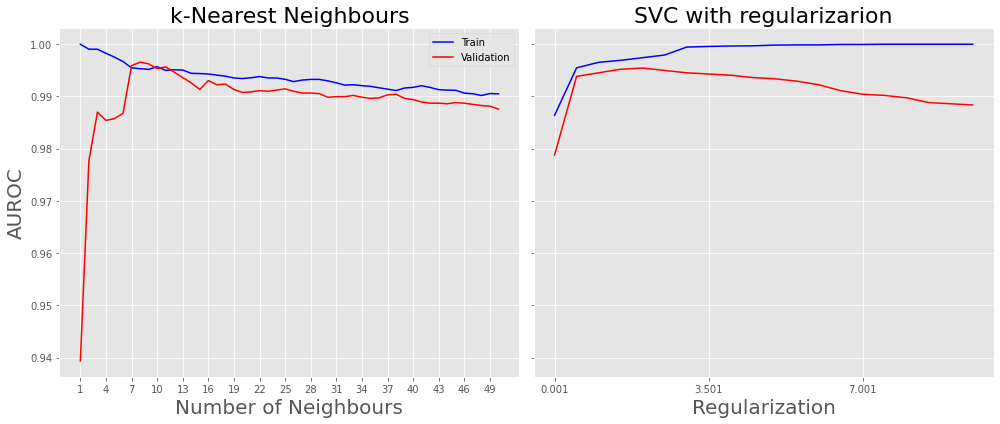

In [ ]:
with plt.style.context(('ggplot')):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    ax1.set_title('k-Nearest Neighbours', size=22)
    ax1.set_ylabel("AUROC", size=20)
    ax1.set_xlabel("Number of Neighbours", size=20)
    ax1.set_xticks(neighbors[::3])
    ax1.plot(neighbors, knn_train_auroc, c="b", label="Train")
    ax1.plot(neighbors, knn_val_auroc, c="r", label="Validation")
    ax1.legend()
    ax2.set_title('SVC with regularizarion', size=22)
    ax2.set_xlabel('Regularization', size=20)
    ax2.set_xticks(regularization[::7])
    ax2.plot(regularization, sc_train_auroc, c='b', label='Train')
    ax2.plot(regularization, sc_val_auroc, c='r', label='Validation')
    fig.tight_layout()

In [ ]:
max(knn_val_auroc), max(sc_val_auroc)

(0.9965800273597811, 0.9954400364797081)

In [ ]:
neighbors[np.argmax(knn_val_auroc)]

8

In [ ]:
regularization[np.argmax(sc_val_auroc)]

2.001

In [ ]:
# Final evaluation

knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)
y_score=knn.predict_proba(X_test)[:, 1]

roc_auc_score(y_test, y_score)

0.9899140211640212

### Плюсы

* Ура, получили какую-то оценку. Для больших датасетов хватает и этого подхода для получения оценки алгоритма

### Минусы 

* Точечная оценка, причём чем меньше примеров в валидационном наборе, тем выше 
дисперсия;
* Снижение размера данных, которые попадают в модель при обучении. 

## Monte-Carlo cross-validation 

Повторение процедуры holdout несколько раз. Есть варианты, когда на каждой итерации варьируется размер валидационной выборки. 

## поправить test на валидацию

<img src="https://kodomo.fbb.msu.ru/FBB/year_21/montecarlo_val.png" width="500">

Можно использовать <a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html'>ShuffleSplit</a> и <a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html'>StratifiedShuffleSplit</a> из sklearn.model_selection, можно наколхозить.<br>
Если нарушается i.i.d., то существует <a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html'>GroupShuffleSplit</a>.

<b>Учтите!</b><br>
Здесь и дальше манипуляции с признаками (шкалирование и пр.) надо производить внутри цикла. Нормализация (и другие сходные операции) по всему датасету приведёт к переобучению (вы показываете модели больший кусок распределения, чем есть в обучающей выборке).

In [ ]:
def get_monte_carlo_cv_scores(X, y, clf, n_samples,
                              test_size='random', random_state=12345):
    rng = np.random.RandomState(seed=random_state)
    seeds = np.arange(10**5)
    rng.shuffle(seeds)
    seeds = seeds[:n_samples]
    auroc_mccv = []
    if test_size == 'random':
        sizes = rng.choice(np.linspace(0.05, 0.5, 46),
                           size=n_samples, replace=True)
        for i, size in zip(seeds, sizes):
            X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                              test_size=size,
                                                              random_state=i,
                                                              stratify=y)
            scaler = StandardScaler().fit(X_train)
            X_train = scaler.transform(X_train)
            X_val = scaler.transform(X_val)
            y_score = clf.fit(X_train, y_train).predict_proba(X_val)[:, 1]
            auroc = roc_auc_score(y_true=y_val, y_score=y_score)
            auroc_mccv.append(auroc)
    elif isinstance(test_size, float):
        for i in seeds:
            X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                              test_size=test_size,
                                                              random_state=i,
                                                              stratify=y)
            scaler = StandardScaler().fit(X_train)
            X_train = scaler.transform(X_train)
            X_val = scaler.transform(X_val)
            y_score = clf.fit(X_train, y_train).predict_proba(X_val)[:, 1]
            auroc = roc_auc_score(y_true=y_val, y_score=y_score)
            auroc_mccv.append(auroc)
    else:
        return 'Wrong test_size type. Must be string ("random") or float'
    return np.array(auroc_mccv)

In [ ]:
def plot_mccv_results(auroc, title):
    with plt.style.context(('ggplot')):
        plt.figure(figsize=(12, 6))
        plt.title(title, size=22)
        plt.bar(range(0, auroc.shape[0]), auroc, color='gray', alpha=0.7)
        plt.axhline(auroc.max(), color='k', linewidth=1, linestyle='--')
        plt.axhline(auroc.min(), color='k', linewidth=1, linestyle='--')
        plt.axhspan(auroc.min(), auroc.max(), alpha=0.2, color='steelblue')
        plt.ylim([0, auroc.max() + 0.1])
        plt.xlabel('Repetition')
        plt.ylabel('AUROC')
        plt.ylim([0.5, 1.0])
        plt.tight_layout()
        plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=100, 
                                                    stratify=y)

clf = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)

auroc_mccv_50 = get_monte_carlo_cv_scores(X_train, y_train, clf, 100, .5)
auroc_mccv_10 = get_monte_carlo_cv_scores(X_train, y_train, clf, 100, .1)
auroc_mccv_random = get_monte_carlo_cv_scores(X_train, y_train, clf, 100)

In [ ]:
auroc_mccv_50.mean(), auroc_mccv_10.mean(), auroc_mccv_random.mean()

(0.969702591526121, 0.973367139959432, 0.9717028934358618)

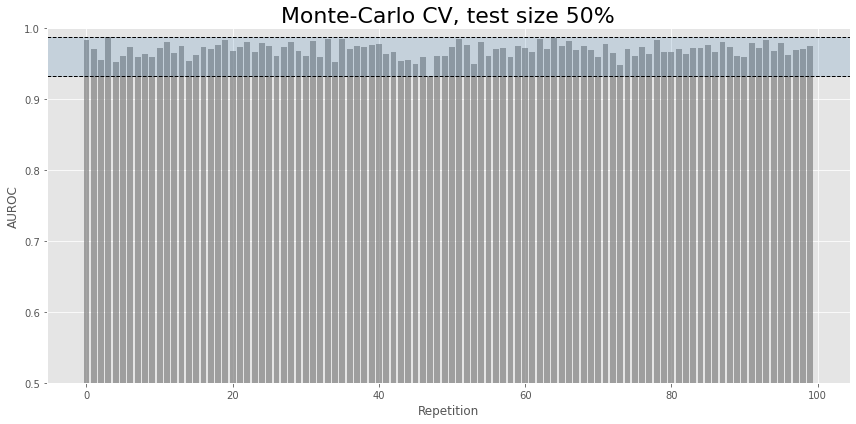

In [ ]:
plot_mccv_results(auroc_mccv_50, 'Monte-Carlo CV, test size 50%')

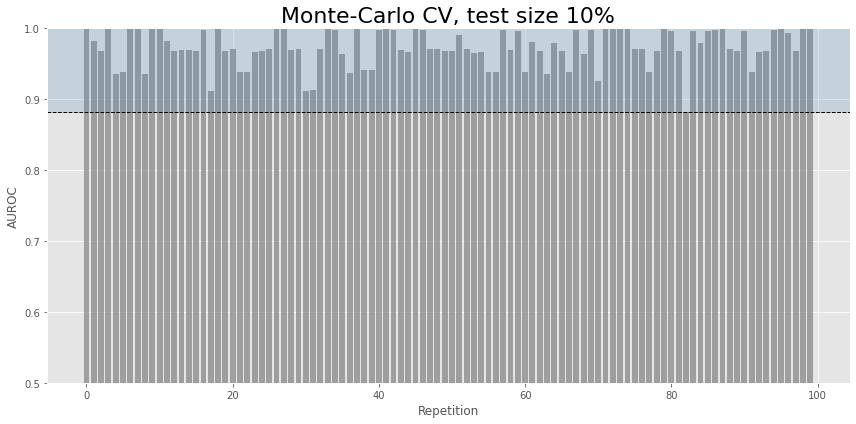

In [ ]:
plot_mccv_results(auroc_mccv_10, 'Monte-Carlo CV, test size 10%')

### Плюсы 

* Получаем массив оценок, можно оценить дисперсию оценки, строить интервалы, применять статтесты и пр.;
* Более гибкая схема валидации, можно придумать свои модификации этого метода (например, зашумлять объекты - аугментация данных).

### Минусы 

* Нет гарантии, что каждый объект попадёт в обучение;
* Надо обучать алгоритм много раз, может быть трудоёмко по времени.

## K-Fold cross-validation 

В общем виде выглядит вот так:

![cv-scheme](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

Крайние примеры - leave-one-out (LOO, n разбиений, в тестовую выборку попадает по одному объекту) и 2-fold (два разбиения 50/50). 


В sklearn.model_selection реализованы многие модификации метода:
 
* <a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html'>KFold</a> - классическая схема;
* <a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html'>StratifiedKFold</a> - k разбиений со стратификацией по меткам классов;
* <a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html'>GroupKFold</a> - k блоков с учётом групп для задач с нарушением i.i.d. (наличием multiple sources);
* <a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html'>LeaveOneOut</a> - классический LOO;
* <a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeavePOut.html'>LeavePOut</a> - в тест попадают все возможные наборы из p объектов (всего $C_n^p$)
* <a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html'>LeaveOneGroupOut</a> - LOO для multiple sources;
* <a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeavePGroupsOut.html'>LeavePGroupsOut</a> - LPO для mutiple sources. 
* некоторые другие.

In [ ]:
from sklearn.model_selection import StratifiedKFold
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=100, stratify=y)
 
clf = LogisticRegression(random_state=1)
skf_scores = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
for train_index, test_index in cv.split(X_train, y_train):
    X_train_, y_train_ = X_train[train_index], y_train[train_index]
    X_val, y_val = X_train[test_index], y_train[test_index]
    scaler = StandardScaler().fit(X_train_)
    X_train_ = scaler.transform(X_train_)
    X_val = scaler.transform(X_val)
    clf.fit(X_train_, y_train_)
    pred = clf.predict_proba(X_val)[:, 1]
    skf_scores.append(roc_auc_score(y_val, pred))
skf_scores = np.array(skf_scores)

In [ ]:
skf_scores.mean(), skf_scores.std()

(0.9922600619195047, 0.007355430208959968)

### Плюсы 
* Гарантия попадания каждого объекта и в трейн, и в тест;
* Получаем массив оценок;
* Гибкость.

### Минусы 

* Непонятно, сколько блоков брать (чаще всего - 5 или 10, но очень зависит от данных и задачи);
* Опять надо обучаться много раз (в случае LPO - очень много), может быть трудоёмко по времени;
* В случае LOO - высокая дисперсия оценки, невозможность подсчитать некоторые метрики (тот же AUROC). Часть метрик для большого числа объектов можно высчитать аналитически - валидация фактически не работает

## Кросс-валидация для временных рядов


![alttext](https://miro.medium.com/max/1204/1*qvdnPF8ETV9mFdMT0Y_BBA.png)

![alttext](https://miro.medium.com/max/1210/1*QJaeOqGfe_vKbpmT882APA.png)

## Кросс-валидация для биологических данных

Более того - **учитывайте**, что правильное разбиение важно не только при делении трайн-тест, но и при кросс-валидации, которую мы разберем далее


Иначе ваша валидация будет кросс-валидация бесмысленна - данные текут, выбирается модель, которая лучше всего ловит эту утечку, а не так, которая лучше всего генерализует решение